# WQD 7012 Applied Machine Learning Assignment

## Assignment Details

- Title: Optimizing Loan Approval Decisions with Machine Learning Models
- Date: April 8, 2025

## 1. Intial Setup

Import some of the useful libraries and load the data for usage in other section. If you haven't install any of the package, type this in the terminal for installation:

```bash
py -m pip install <package_name>

# if you have a few version of python in your system
py -3.10 pip install <package_name>
py -3.11 pip install <package_name>
py -3.12 pip install <package_name>
py -3.13 pip install <package_name>
```

In [1]:
# import libraries
import pandas as pd
import warnings 
import numpy as np
import os

# turn off warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# load and preview the data
df = pd.read_csv('data/data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## 2. Data Understanding

This section probably will include steps like showing the shape of the data, the summary statistics, counting the unique values, and checking the data types. The goal is to understand the data better before we start the analysis.


In [3]:
# check the shape of the data

## 3. Exploratory Data Analysis

This section will include steps like visualizing the data, checking for missing values, and understanding the distribution of the data. The goal is to understand the data better before we start the analysis.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Check for missing values
missing = df.isna()
n_missing = df[missing].sum()
print(f'Missing values: \n {n_missing}')

# check duplicates
df.duplicated().sum()

Missing values: 
 person_age                        0.0
person_gender                       0
person_education                    0
person_income                     0.0
person_emp_exp                    0.0
person_home_ownership               0
loan_amnt                         0.0
loan_intent                         0
loan_int_rate                     0.0
loan_percent_income               0.0
cb_person_cred_hist_length        0.0
credit_score                      0.0
previous_loan_defaults_on_file      0
loan_status                       0.0
dtype: object


np.int64(0)

There is no missing and duplicate value in the data.

In [5]:
# statistical information about the data
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [6]:
# separate feature dataframes
# categorical features
c_column = ["person_gender", "person_education", "person_home_ownership", "previous_loan_defaults_on_file", "loan_intent"]
# numerical features
n_column = ["person_age", "person_income", "person_emp_exp", "loan_amnt","loan_int_rate",
        "loan_percent_income","cb_person_cred_hist_length","credit_score"]

### Check Outliers

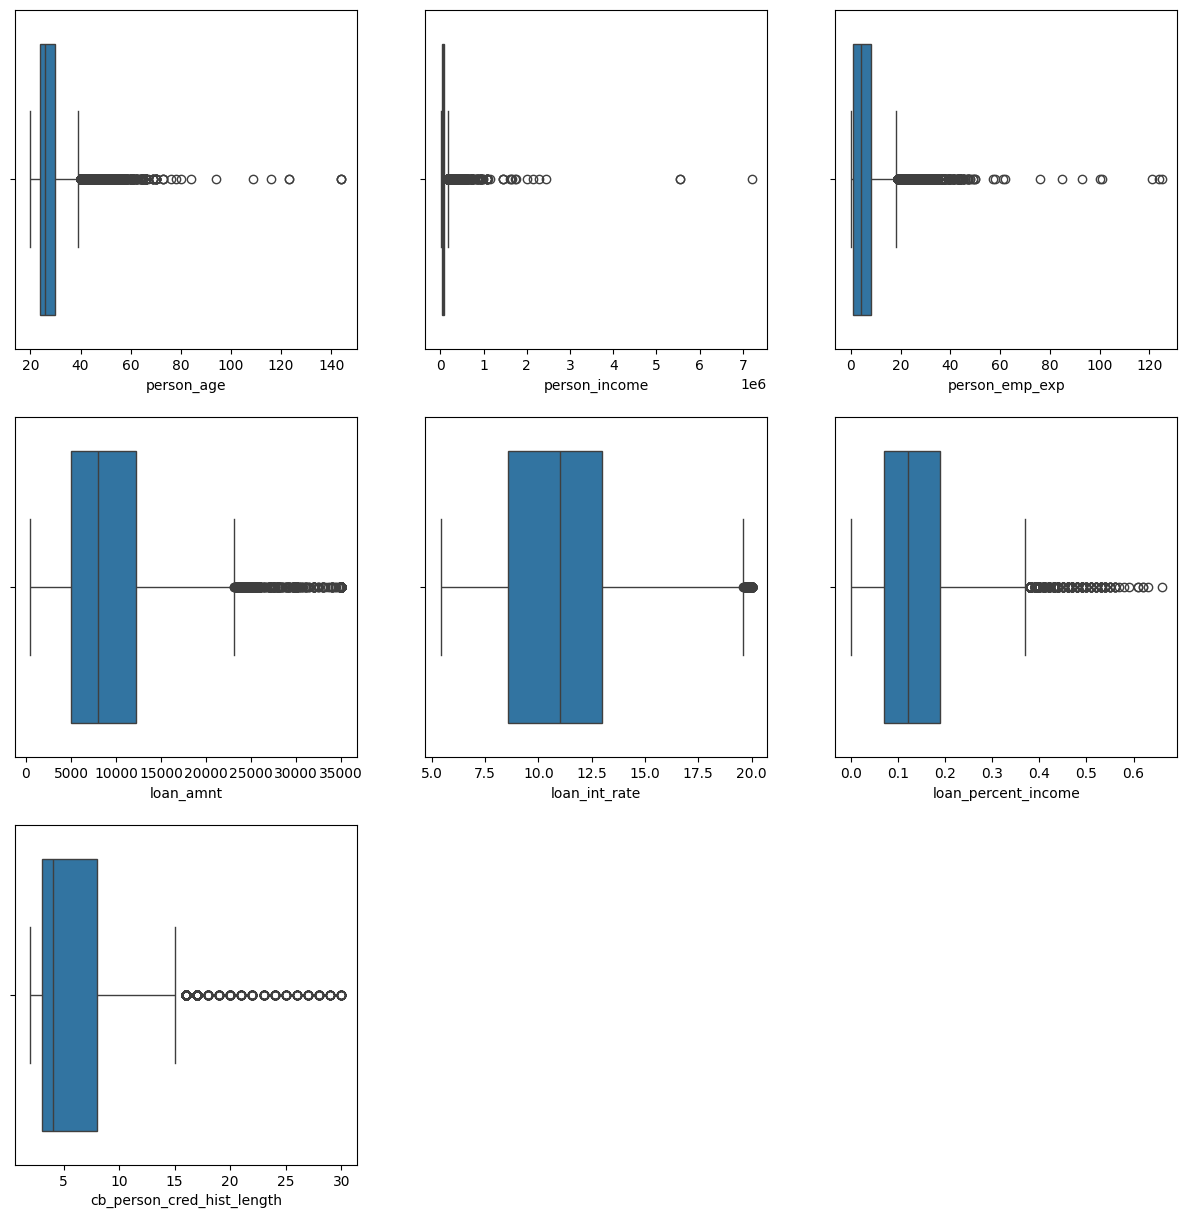

In [7]:
# Boxplot numerical columns 
plt.figure(figsize=(15,15))
for i,col in zip(range(1,len(n_column)),df[n_column]) : 
    plt.subplot(3,3,i)
    sns.boxplot(data = df , x=df[col])
plt.show()

- All numerical features have outliers.
- Maximum value of "person_age" and "person_emp_exp" are greater than 100, which is weird. This may due to data entry error. We need to do some pre-processing to correct the errors.

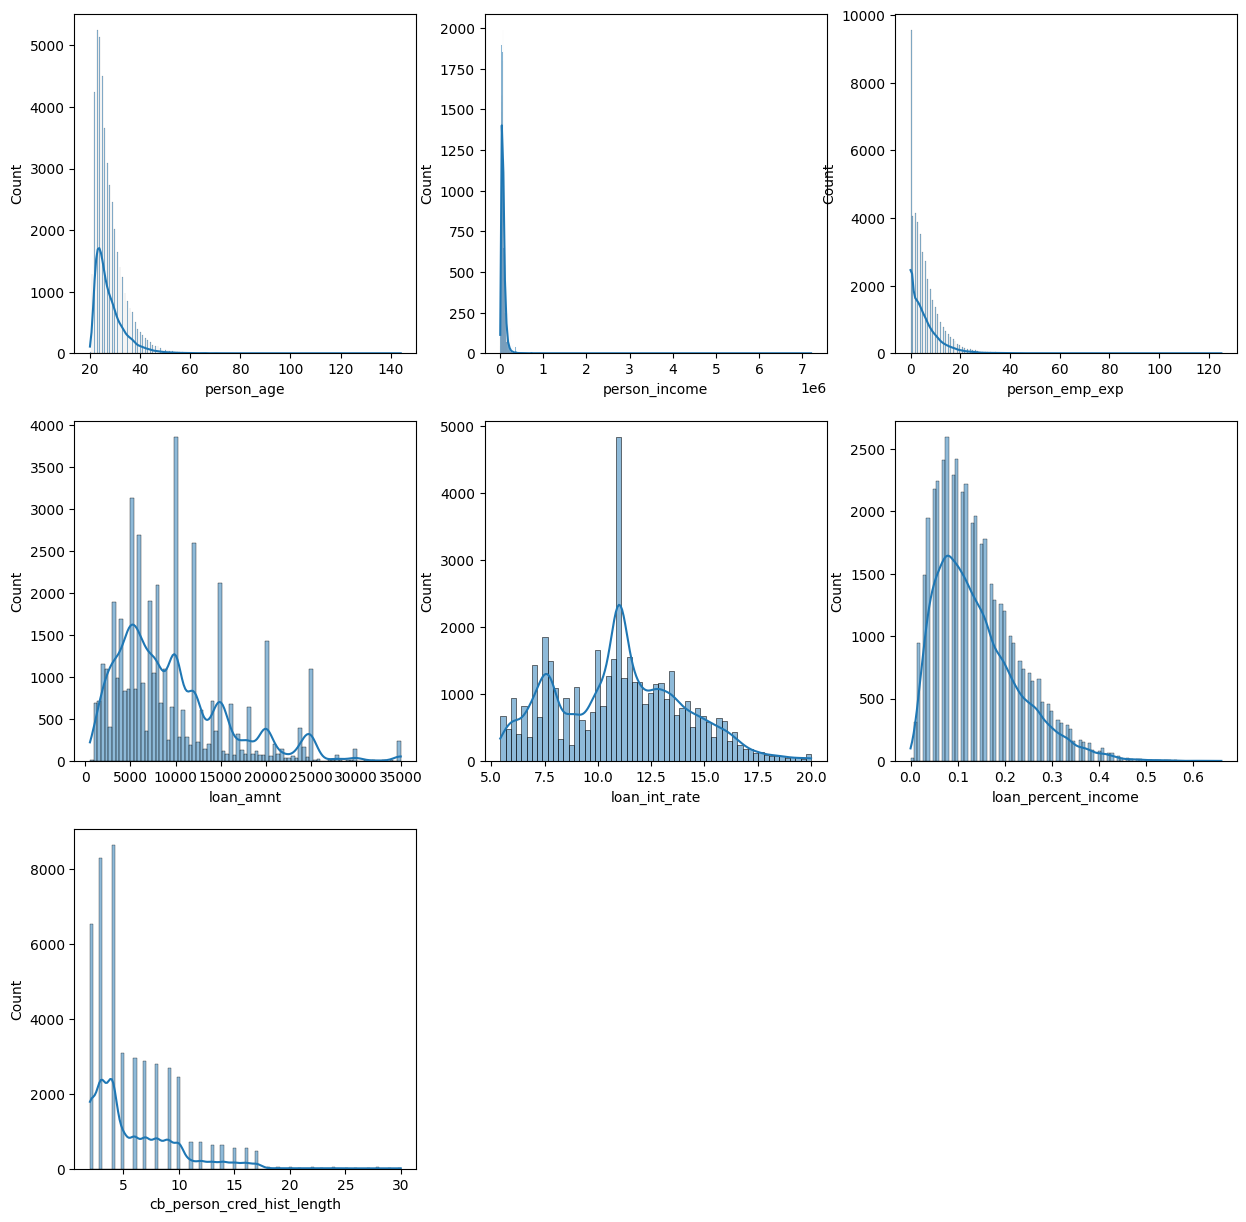

In [8]:
# Histogram
plt.figure(figsize=(15,15))
for i,col in zip(range(1,len(n_column)),df[n_column]):
    plt.subplot(3,3,i)
    sns.histplot(data=df, x=df[col],kde=True)
plt.show()

We noticed that some features are rightly skewed which would need normalization before modelling.

In [10]:
# Detect Outliers
def detect_outliers(df, numerical_cols, lower_factor=1.5, upper_factor=1.5):
    outlier_data = pd.DataFrame()
    all_outliers_idx = set()  # Track indices of outliers

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - lower_factor * IQR
        upper_bound = Q3 + upper_factor * IQR

        if not df.empty:
            print(f"{col}: Min Value = {df[col].min()}, Max Value = {df[col].max()}")
            print(f"{col}: Lower Bound = {lower_bound}, Upper Bound = {upper_bound}\n")

        outliers = df[(df[col] > upper_bound) | (df[col] < lower_bound)]
        all_outliers_idx.update(outliers.index)  # Store outlier indices
    
    # Separate outliers and cleaned data
    outlier_data = df.loc[list(all_outliers_idx)]
    df_cleaned = df.drop(index=all_outliers_idx)

    print("Outliers detected and stored in 'outlier_data'. Remaining data cleaned.")

    return df_cleaned, outlier_data

In [11]:
# Apply function
dfCleaned, outlierData = detect_outliers(df, n_column , 1.5 , 1.5)

person_age: Min Value = 20.0, Max Value = 144.0
person_age: Lower Bound = 15.0, Upper Bound = 39.0

person_income: Min Value = 8000.0, Max Value = 7200766.0
person_income: Lower Bound = -25673.875, Upper Bound = 168667.125

person_emp_exp: Min Value = 0, Max Value = 125
person_emp_exp: Lower Bound = -9.5, Upper Bound = 18.5

loan_amnt: Min Value = 500.0, Max Value = 35000.0
loan_amnt: Lower Bound = -5855.875, Upper Bound = 23093.125

loan_int_rate: Min Value = 5.42, Max Value = 20.0
loan_int_rate: Lower Bound = 1.9899999999999993, Upper Bound = 19.59

loan_percent_income: Min Value = 0.0, Max Value = 0.66
loan_percent_income: Lower Bound = -0.10999999999999999, Upper Bound = 0.37

cb_person_cred_hist_length: Min Value = 2.0, Max Value = 30.0
cb_person_cred_hist_length: Lower Bound = -4.5, Upper Bound = 15.5

credit_score: Min Value = 390, Max Value = 850
credit_score: Lower Bound = 497.5, Upper Bound = 773.5

Outliers detected and stored in 'outlier_data'. Remaining data cleaned.


In [12]:
# Validate total count
print(f"Cleaned Shape: {dfCleaned.shape[0]}")
print(f"Outlier Shape: {outlierData.shape[0]}")
print(f"Sum of Cleaned & Outliers: {dfCleaned.shape[0] + outlierData.shape[0]}")

Cleaned Shape: 37549
Outlier Shape: 7451
Sum of Cleaned & Outliers: 45000


In [13]:
# try to fix working exp/ ages that has data entry error
adjusted_data = outlierData[(outlierData["person_emp_exp"] > 60) | (outlierData["person_age"]>100)].copy() 
adjusted_data["person_emp_exp"] = adjusted_data["person_emp_exp"].apply(lambda x: x % 100 if x > 100 else 0)
adjusted_data["person_age"] = adjusted_data["person_age"].apply(lambda x: x % 100 if x > 120 else 0)

In [14]:
# Final data
myFinalData = pd.concat([dfCleaned,
                         adjusted_data[(adjusted_data['person_emp_exp']>0) & (adjusted_data['person_age']>0) ]]) 
myFinalData

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1
11,21.0,female,Associate,13113.0,0,OWN,4500.0,HOMEIMPROVEMENT,8.63,0.34,2.0,651,No,1
19,24.0,female,Master,14283.0,1,MORTGAGE,1750.0,EDUCATION,10.99,0.12,2.0,679,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44999,24.0,male,High School,51609.0,1,RENT,6665.0,DEBTCONSOLIDATION,17.05,0.13,3.0,628,No,1
81,44.0,male,Bachelor,300616.0,25,RENT,4800.0,VENTURE,13.57,0.02,3.0,789,No,0
183,44.0,male,Associate,241424.0,21,MORTGAGE,6000.0,EDUCATION,11.86,0.02,2.0,807,No,0
575,23.0,female,High School,97140.0,1,RENT,20400.0,EDUCATION,10.25,0.21,3.0,805,Yes,0


In [15]:
myFinalData.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,37553.000000,3.755300e+04,37553.000000,37553.000000,37553.000000,37553.000000,37553.000000,37553.000000,37553.000000
mean,26.615397,6.984778e+04,4.281575,8422.294198,10.899261,0.134039,5.173222,632.510106,0.212686
std,4.112721,4.853899e+04,4.140316,4868.664049,2.927013,0.077015,2.899797,47.712251,0.409213
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,498.000000,0.000000
25%,23.000000,4.561900e+04,1.000000,4889.000000,8.490000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.411700e+04,3.000000,7500.000000,11.010000,0.120000,4.000000,639.000000,0.000000
75%,29.000000,8.782900e+04,7.000000,11965.000000,12.980000,0.180000,7.000000,668.000000,0.000000
max,44.000000,7.200766e+06,25.000000,23000.000000,19.530000,0.370000,25.000000,850.000000,1.000000


C:\Users\tanye\AppData\Local\Temp\ipykernel_14260\2741025690.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = 'loan_status', data = myFinalData, palette = {'0': 'lightgrey', '1': 'darkorange'})


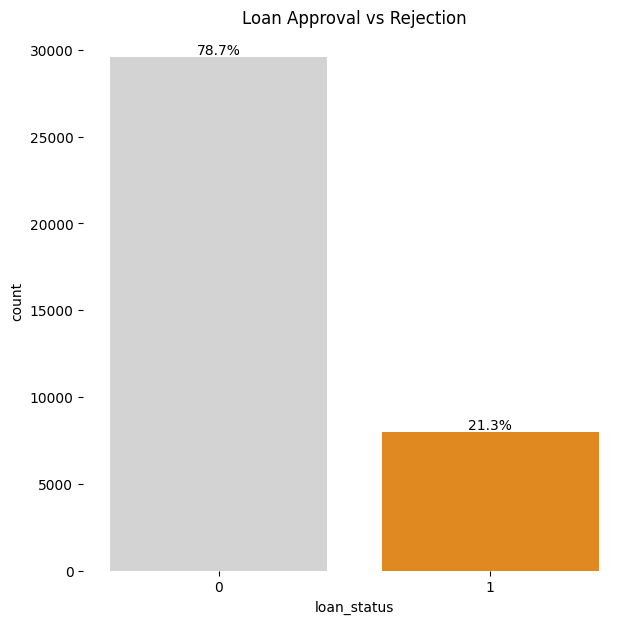

In [16]:
# visualize loan status
plt.figure(figsize = (7,7))

ax = sns.countplot(x = 'loan_status', data = myFinalData, palette = {'0': 'lightgrey', '1': 'darkorange'})
sns.despine(left = True, bottom = True)

# To display the percentage
total = len(myFinalData)

for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x,y = p.get_xy()
    ax.text(x + width / 2, y + height, f'{height/total:.1%}', ha = 'center', va = 'bottom')

plt.title('Loan Approval vs Rejection')
plt.show()

Observing the values of loan approval status shows that the classes are imbalanced - there are far more rejected loan application than approved loan. This is important to note, we may need to balance the classes or apply cross-validation to improve model prediction accuracy.

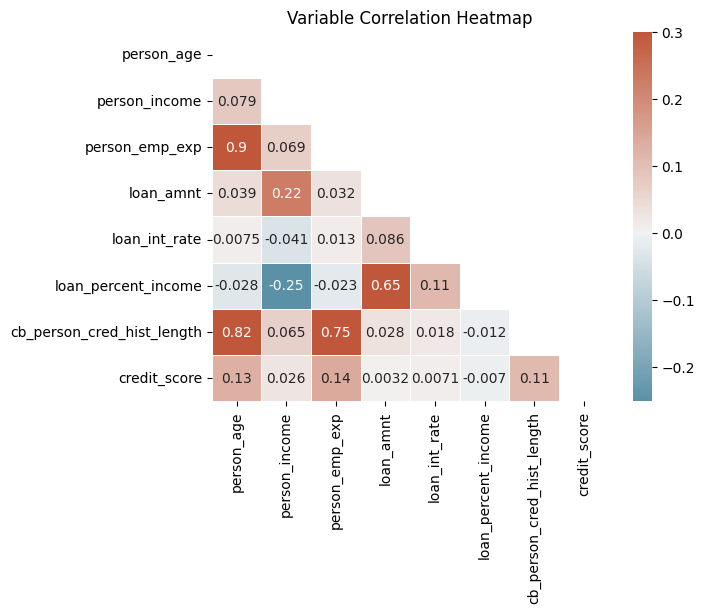

In [17]:
# correlation matrix
corr = myFinalData[n_column].corr()

# heatmap
plt.figsize = (11,11)

mask = np.triu(np.ones_like(corr, dtype = bool))
cmap = sns.diverging_palette(227, 21, as_cmap = True)

sns.heatmap(corr, annot=True, mask = mask, cmap = cmap, vmax = .3, center = 0, linewidths = 0.5)
plt.title('Variable Correlation Heatmap')
plt.show()

- Credit history grows with age and work experience. (expected)
- The loan-to-income ratio increases as the loan amount increases (income remain constant). A high loan amount relative to income might signal financial strain, which could impact loan approval.
- The higher the income, the lower the percentage of income the loan represents. Applicants with higher incomes appear less risky in terms of repayment burden

C:\Users\tanye\AppData\Local\Temp\ipykernel_14260\382462308.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, ha = 'right')
C:\Users\tanye\AppData\Local\Temp\ipykernel_14260\382462308.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, ha = 'right')
C:\Users\tanye\AppData\Local\Temp\ipykernel_14260\382462308.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, ha = 'right')
C:\Users\tanye\AppData\Local\Temp\ipykernel_14260\382462308.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set

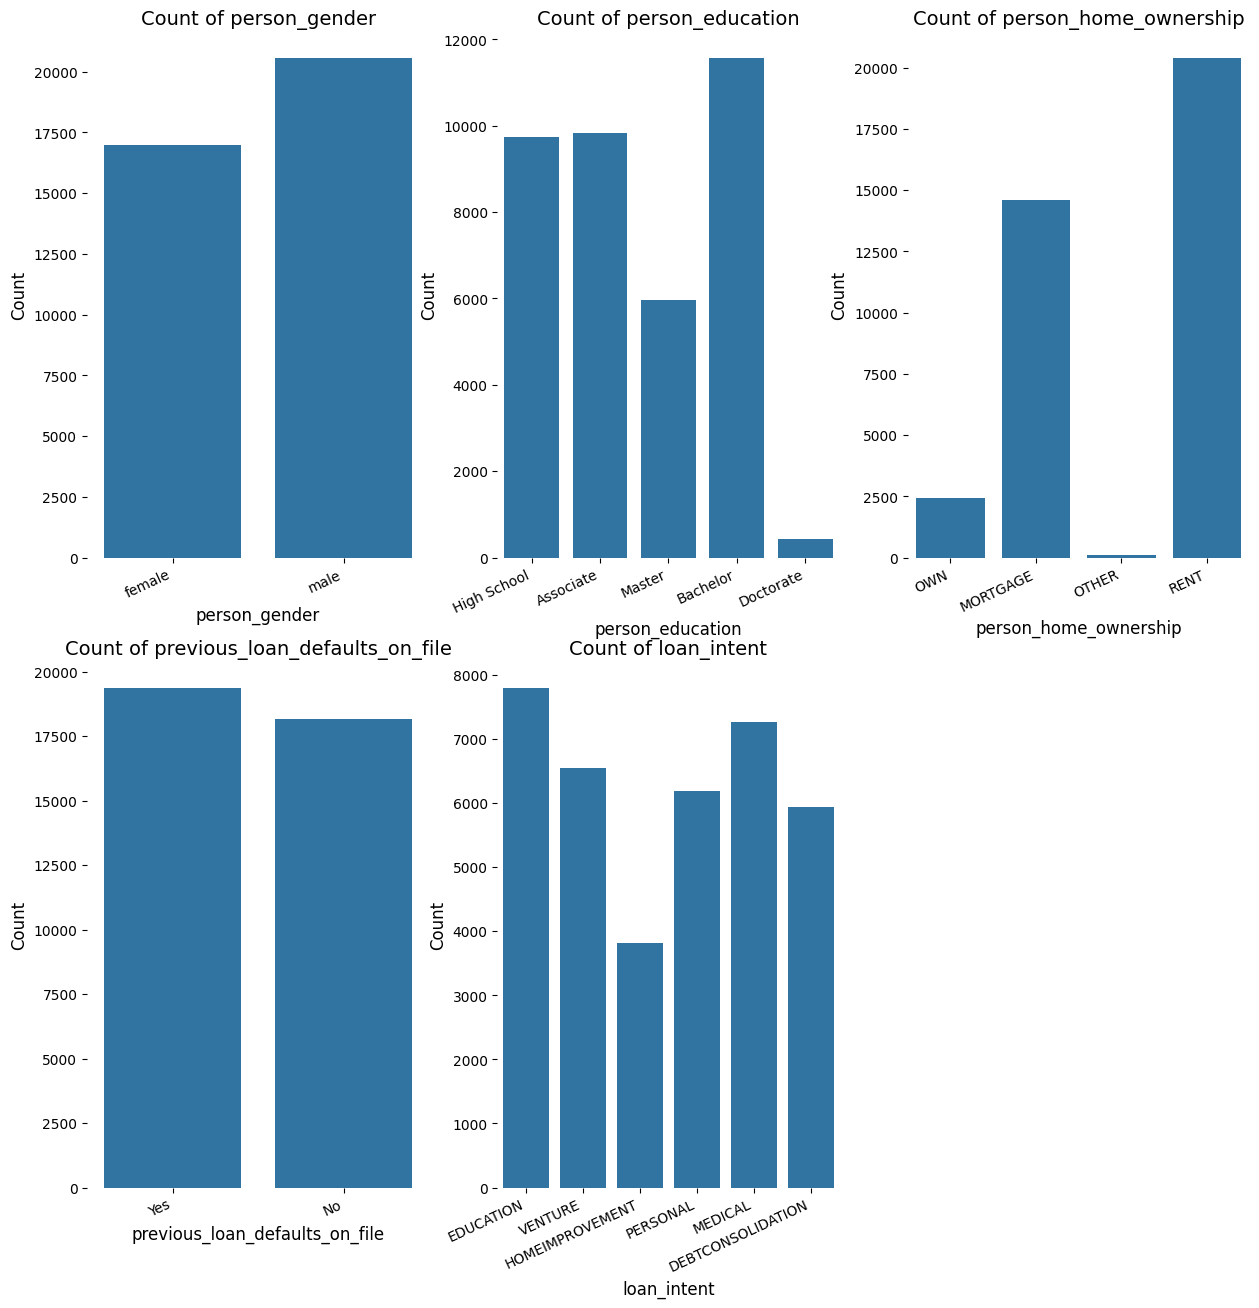

In [18]:
# categorical features bivariate analysis
# visualisation grid
plt.figure(figsize=(15,15))
for i,col in zip(range(1,len(c_column)+1),myFinalData[c_column]):
    ax = plt.subplot(2,3,i)

    sns.countplot(data=myFinalData, x=myFinalData[col])
    sns.despine(left = True, bottom = True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 25, ha = 'right')
    ax.legend_ = None

    plt.title(f"Count of {col}", fontsize=14) 
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)

plt.show()

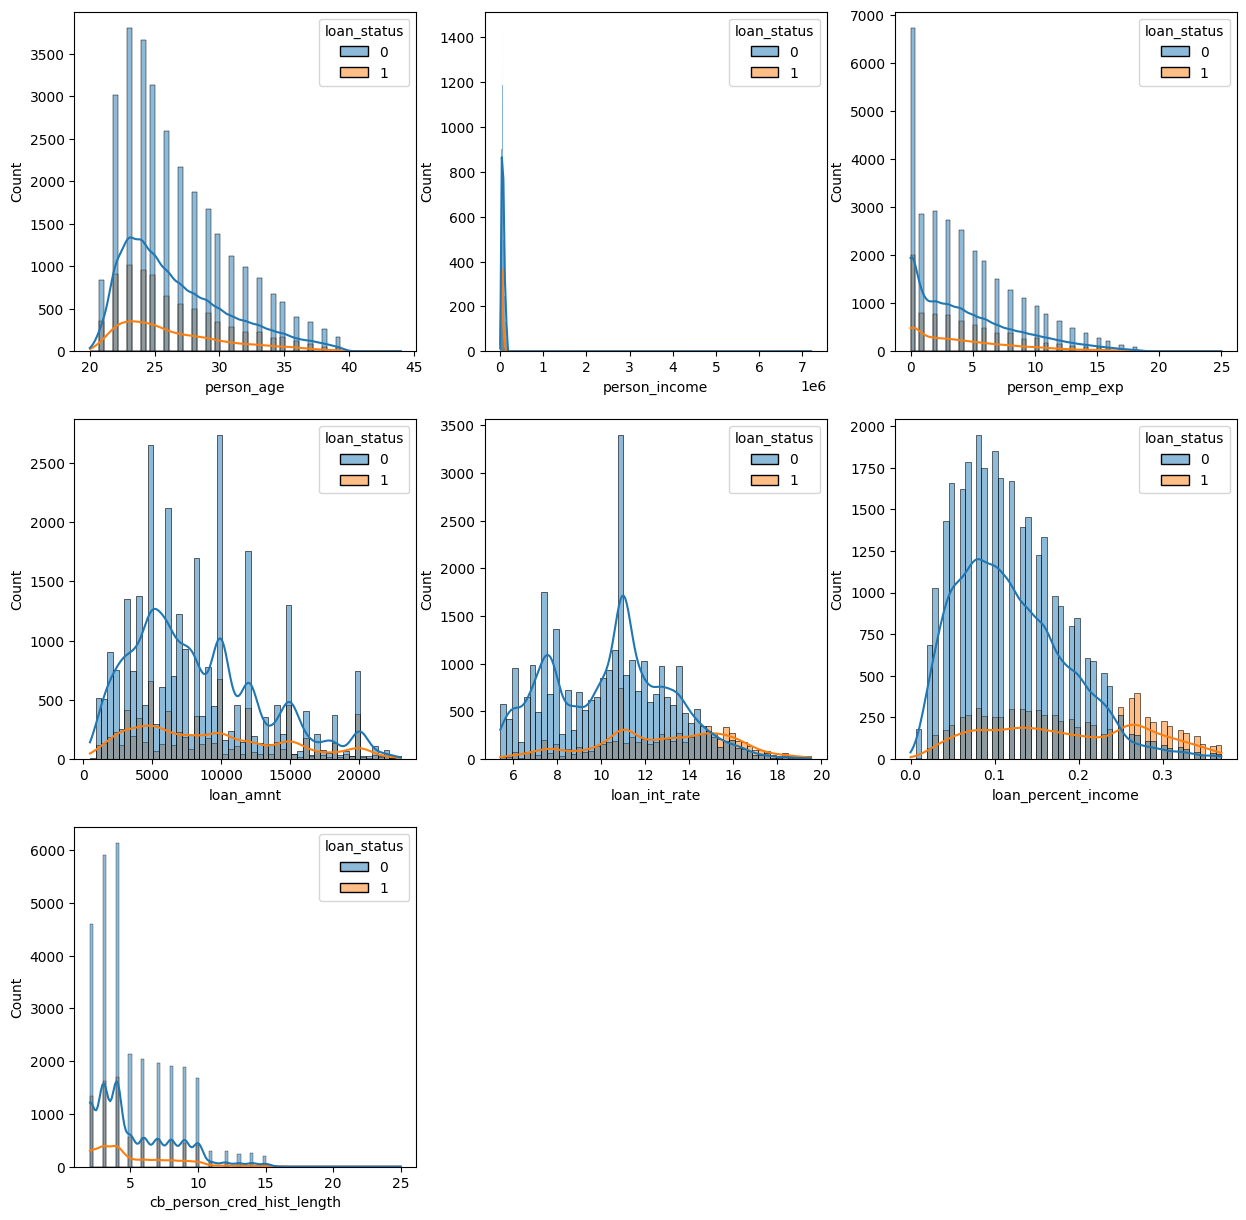

In [19]:
# numerical feature bivariate analysis
# visualisation grid
# Histogram
plt.figure(figsize=(15,15))
for i,col in zip(range(1,len(n_column)),myFinalData[n_column]):
    plt.subplot(3,3,i)
    sns.histplot(data=myFinalData, x=myFinalData[col],hue= 'loan_status',kde=True)
plt.show()

- Most of applicants between 21-26 years old.
- Surprisingly, loan approval rate increases for loan percent income > 25%

## 4. Data Preprocessing

This section will include steps like handling missing values, encoding categorical variables, and scaling the data. The goal is to prepare the data for modeling.

In [6]:
# shows the missing value
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Missing values in the dataset:")
print(missing_values)

Missing values in the dataset:
Series([], dtype: int64)


In [8]:
# shows unique value of categorical columns
print("\nUnique values in categorical columns:")
for col in df.select_dtypes(include=['object']).columns:
    unique_values = df[col].unique()
    print(f"{col}: {len(unique_values)} unique values")
    print(unique_values[:5])  # show only the first 5 unique values
    print()


Unique values in categorical columns:
person_gender: 2 unique values
['female' 'male']

person_education: 5 unique values
['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']

person_home_ownership: 4 unique values
['RENT' 'OWN' 'MORTGAGE' 'OTHER']

loan_intent: 6 unique values
['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT']

previous_loan_defaults_on_file: 2 unique values
['No' 'Yes']



## 5. Modelling

This section will include steps like splitting the data into training and testing sets, training the model, and evaluating the model. The goal is to build a model that can predict the target variable accurately.

## 6. Evaluation

This section will include steps like evaluating the model using various metrics, such as accuracy, precision, recall, and F1 score. The goal is to understand how well the model performs on the test data.